In [1]:
!pip -q install -U scikit-learn

import os, random, numpy as np, torch
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)
torch.backends.cudnn.benchmark = False

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 54.2 MB/s eta 0:00:00


'cpu'

In [2]:
from google.colab import files

uploaded = files.upload()
RAW_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt"


Saving WISDM_ar_v1.1_raw.txt to WISDM_ar_v1.1_raw.txt


In [3]:
import pandas as pd

cols = ["user","activity","timestamp","x","y","z"]
df = pd.read_csv(
    RAW_PATH, header=None, names=cols,
    engine="python", on_bad_lines="skip"
)

df["z"] = df["z"].astype(str).str.replace(";", "", regex=False)
for a in ["x","y","z"]:
    df[a] = pd.to_numeric(df[a], errors="coerce")
df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")
df["user"] = df["user"].astype(str).str.strip()

df = df.dropna(subset=["x","y","z","activity","user","timestamp"])
df = df[df["timestamp"] > 0]
df = df.sort_values(["user","timestamp"]).reset_index(drop=True)

valid_labels = ["Walking","Jogging","Upstairs","Downstairs","Sitting","Standing"]
df = df[df["activity"].isin(valid_labels)].copy()

print("유저 수:", df["user"].nunique())
print("총 행 수:", len(df))
print("\n활동 분포(상위 6개 예상):")
print(df["activity"].value_counts())
print("\n가속도 통계:")
display(df[["x","y","z"]].describe())

print("\n축 간 상관:")
display(df[["x","y","z"]].corr())


유저 수: 36
총 행 수: 1073623

활동 분포(상위 6개 예상):
activity
Walking       417901
Jogging       324600
Upstairs      122598
Downstairs    100192
Sitting        59939
Standing       48393
Name: count, dtype: int64

가속도 통계:


,x,y,z
count,1.073623e+06,1.073623e+06,1.073623e+06
mean,6.720567e-01,7.332700e+00,4.024567e-01
std,6.916894e+00,6.732950e+00,4.789301e+00
min,-1.961000e+01,-1.961000e+01,-1.980000e+01
25%,-2.960000e+00,3.340000e+00,-2.260978e+00
50%,3.400000e-01,8.010000e+00,-4.000000e-02
75%,4.520000e+00,1.160000e+01,2.760000e+00
max,1.995000e+01,2.004000e+01,1.961000e+01



축 간 상관:


,x,y,z
x,1.000000,0.027512,0.067604
y,0.027512,1.000000,0.011282
z,0.067604,0.011282,1.000000


In [4]:
import numpy as np

WINDOW_SIZE = 200   # 10초 @ 20Hz
STEP_SIZE   = 100   # 50% overlap

label2id = {l:i for i,l in enumerate(valid_labels)}
id2label = {v:k for k,v in label2id.items()}

def make_windows(group_df, w=WINDOW_SIZE, step=STEP_SIZE):
    Xs, ys = [], []
    arr = group_df[["x","y","z"]].values.astype(np.float32)
    n = len(arr)
    if n < w:
        return Xs, ys
    y = label2id[group_df["activity"].iloc[0]]
    for start in range(0, n - w + 1, step):
        Xs.append(arr[start:start+w])  # (w,3)
        ys.append(y)
    return Xs, ys

Xs, ys, users_win = [], [], []
for (u, act), g in df.groupby(["user","activity"], sort=False):
    Xg, yg = make_windows(g)
    Xs.extend(Xg); ys.extend(yg); users_win.extend([u]*len(yg))

Xs = np.stack(Xs)           # (N, w, 3)
ys = np.array(ys, np.int64)
users_win = np.array(users_win)

# 유저 단위 split(데이터 누수 방지)
uniq_users = sorted(np.unique(users_win))
n = len(uniq_users)
n_train = max(1, int(round(n*0.67)))
n_val   = max(1, int(round(n*0.17)))

train_users = set(uniq_users[:n_train])
val_users   = set(uniq_users[n_train:n_train+n_val])
test_users  = set(uniq_users[n_train+n_val:])

def mask_by(users_set): return np.isin(users_win, list(users_set))
m_tr, m_va, m_te = mask_by(train_users), mask_by(val_users), mask_by(test_users)

X_tr, y_tr = Xs[m_tr], ys[m_tr]
X_va, y_va = Xs[m_va], ys[m_va]
X_te, y_te = Xs[m_te], ys[m_te]

print(f"윈도 개수 -> train:{len(y_tr)}, val:{len(y_va)}, test:{len(y_te)}")
print(f"유저 -> train:{len(train_users)}, val:{len(val_users)}, test:{len(test_users)}")

# 표준화(훈련 기준)
mu = X_tr.reshape(-1,3).mean(axis=0)
sd = X_tr.reshape(-1,3).std(axis=0) + 1e-8
def norm(x): return (x - mu) / sd
X_tr, X_va, X_te = norm(X_tr), norm(X_va), norm(X_te)

# Conv1d 입력(C, T)로 변환
X_tr = np.transpose(X_tr, (0,2,1))  # (N,3,T)
X_va = np.transpose(X_va, (0,2,1))
X_te = np.transpose(X_te, (0,2,1))


윈도 개수 -> train:7049, val:1923, test:1491
유저 -> train:24, val:6, test:6


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class WISDMDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

ds_tr, ds_va, ds_te = WISDMDataset(X_tr, y_tr), WISDMDataset(X_va, y_va), WISDMDataset(X_te, y_te)

BATCH_SIZE = 64
dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=torch.cuda.is_available())
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())


In [6]:
import torch.nn as nn

class CNN1D(nn.Module):
    def __init__(self, n_classes=6, in_ch=3):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256), nn.ReLU(),

            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256), nn.ReLU(),

            nn.AdaptiveAvgPool1d(1)  # (N, C, 1)
        )
        self.head = nn.Sequential(
            nn.Flatten(), nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        x = self.feat(x)
        return self.head(x)

model = CNN1D(n_classes=len(valid_labels)).to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6, DEVICE


(0.372998, 'cpu')

In [7]:
from sklearn.metrics import accuracy_score
import torch

EPOCHS = 20
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

best_val = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in dl_tr:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * len(yb)

    # valid
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for xb, yb in dl_va:
            xb = xb.to(DEVICE)
            logits = model(xb)
            preds.extend(logits.argmax(1).cpu().tolist())
            gts.extend(yb.tolist())
    val_acc = accuracy_score(gts, preds)
    print(f"[{epoch:02d}] train_loss={total_loss/len(ds_tr):.4f}  val_acc={val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        torch.save({"model": model.state_dict(), "mu":mu, "sd":sd, "labels":valid_labels}, "wisdm_cnn_best.pt")
print("best_val_acc:", best_val)


[01] train_loss=0.4666  val_acc=0.8149
[02] train_loss=0.1698  val_acc=0.8950
[03] train_loss=0.1062  val_acc=0.9022
[04] train_loss=0.0763  val_acc=0.9319
[05] train_loss=0.0572  val_acc=0.9048
[06] train_loss=0.0637  val_acc=0.9350
[07] train_loss=0.0418  val_acc=0.9277
[08] train_loss=0.0311  val_acc=0.9246
[09] train_loss=0.0326  val_acc=0.9074
[10] train_loss=0.0360  val_acc=0.9116
[11] train_loss=0.0276  val_acc=0.8903
[12] train_loss=0.0242  val_acc=0.9199
[13] train_loss=0.0235  val_acc=0.9511
[14] train_loss=0.0225  val_acc=0.9553
[15] train_loss=0.0169  val_acc=0.9438
[16] train_loss=0.0264  val_acc=0.9563
[17] train_loss=0.0190  val_acc=0.9594
[18] train_loss=0.0196  val_acc=0.9095
[19] train_loss=0.0232  val_acc=0.9033
[20] train_loss=0.0176  val_acc=0.9620
best_val_acc: 0.9620384815392615


Test accuracy: 0.8994  |  Balanced acc: 0.9289

Classification report:
              precision    recall  f1-score   support

     Walking     0.9983    0.8404    0.9126       708
     Jogging     1.0000    0.9865    0.9932       370
    Upstairs     0.7516    0.8613    0.8027       137
  Downstairs     0.4854    0.8850    0.6270       113
     Sitting     0.9574    1.0000    0.9783        90
    Standing     1.0000    1.0000    1.0000        73

    accuracy                         0.8994      1491
   macro avg     0.8655    0.9289    0.8856      1491
weighted avg     0.9348    0.8994    0.9091      1491



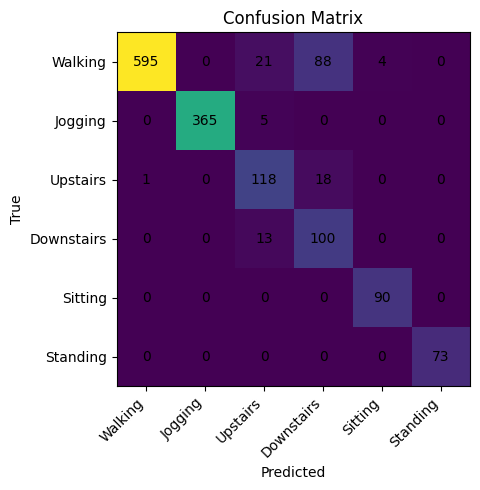

In [9]:
import json
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

ckpt = torch.load("wisdm_cnn_best.pt", map_location="cpu", weights_only=False)
model.load_state_dict(ckpt["model"])
model.to(DEVICE); model.eval()

preds, gts = [], []
with torch.no_grad():
    for xb, yb in dl_te:
        xb = xb.to(DEVICE)
        logits = model(xb)
        preds.extend(logits.argmax(1).cpu().tolist())
        gts.extend(yb.tolist())

from sklearn.metrics import accuracy_score, balanced_accuracy_score
test_acc = accuracy_score(gts, preds)
bal_acc  = balanced_accuracy_score(gts, preds)
print(f"Test accuracy: {test_acc:.4f}  |  Balanced acc: {bal_acc:.4f}")

print("\nClassification report:")
print(classification_report(gts, preds, target_names=valid_labels, digits=4))

cm = confusion_matrix(gts, preds, labels=list(range(len(valid_labels))))
fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xticks(range(len(valid_labels)), valid_labels, rotation=45, ha='right')
plt.yticks(range(len(valid_labels)), valid_labels)
plt.xlabel('Predicted'); plt.ylabel('True')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.tight_layout()
plt.show()

with open("metrics.json","w") as f:
    json.dump({"best_val_acc": float(best_val), "test_acc": float(test_acc), "balanced_acc": float(bal_acc)}, f)